## Neural Network in Pytorch

In [1]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00


In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy : 1.25.2
pandas: 2.0.3
torch : 2.3.0+cu121



In [3]:
# Heavily based on https://github.com/Prodicode/ann-visualizer

def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")
                c.node_attr.update(
                    width="0.65",
                    style="filled",
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],

                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


In [4]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## DATA

Our dataset contain Australian weather, and we're simply predicting if it'll rain tomorrow or not.

In [5]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
df.shape

(145460, 23)

## Data Preprocessing

### We'll use only 4 columns for predicting whether or not is going to rain tomorrow:

In [8]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

In [9]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

In [10]:
df = df.dropna(how='any')
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0.0
1,0.0,25.0,1010.6,0.0,0.0
2,0.0,30.0,1007.6,0.0,0.0
3,0.0,16.0,1017.6,0.0,0.0
4,1.0,33.0,1010.8,0.0,0.0


In [12]:
df.RainTomorrow.value_counts() / df.shape[0]

RainTomorrow
0.0    0.778762
1.0    0.221238
Name: count, dtype: float64

About 78% of the data points have a non-rainy day for tomorrow. This means that a model that predicts there will be no rain tomorrow will be correct about 78% of the time

final step is to split data into train, test data

In [13]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [14]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


## Build a Neural Network

Our input contains data from the four columns: Rainfall, Humidity3pm, RainToday, Pressure9am. We'll create an appropriate input layer for that.

The output will be a number between 0 and 1, representing how likely (our model thinks) it is going to rain tomorrow. The prediction will be given to us by the final (output) layer of the network.

We'll add two (hidden) layers between the input and output layers. The parameters (neurons) of those layer will decide the final output. All layers will be fully-connected.

In [15]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

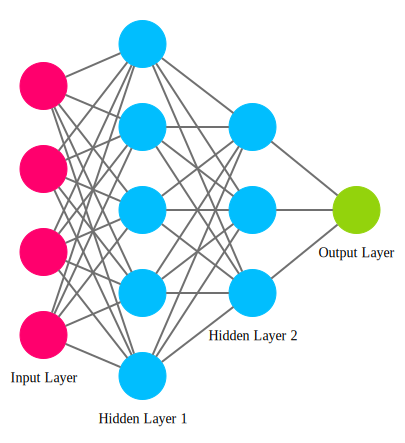

In [16]:
net = Net(X_train.shape[1])

ann_viz(net, view=False)

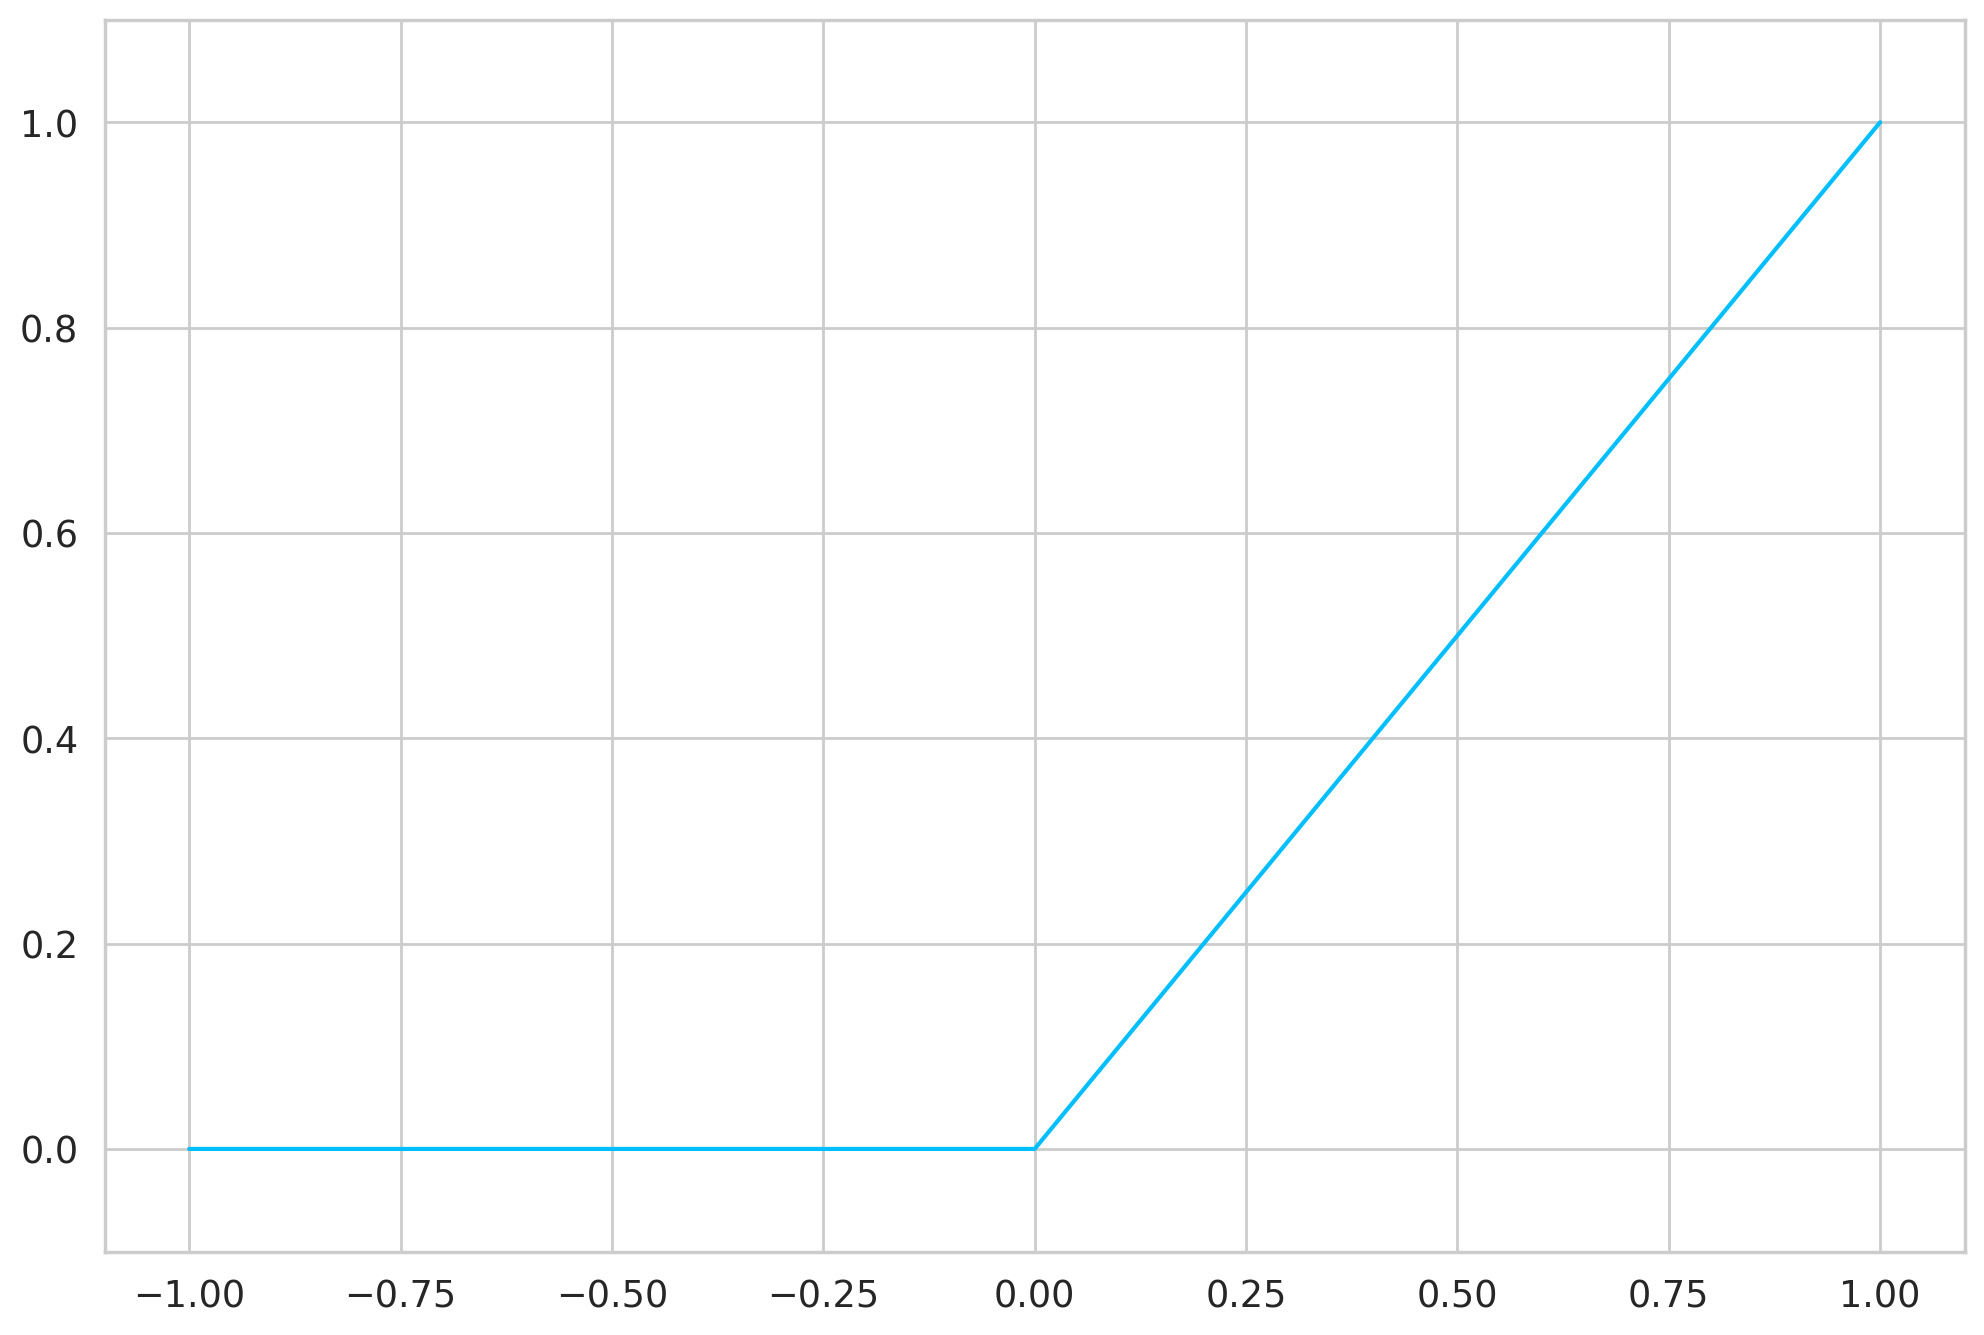

In [17]:
ax = plt.gca()

plt.plot(
  np.linspace(-1, 1, 5),
  F.relu(torch.linspace(-1, 1, steps=5)).numpy()
)
ax.set_ylim([-0.1, 1.1]);

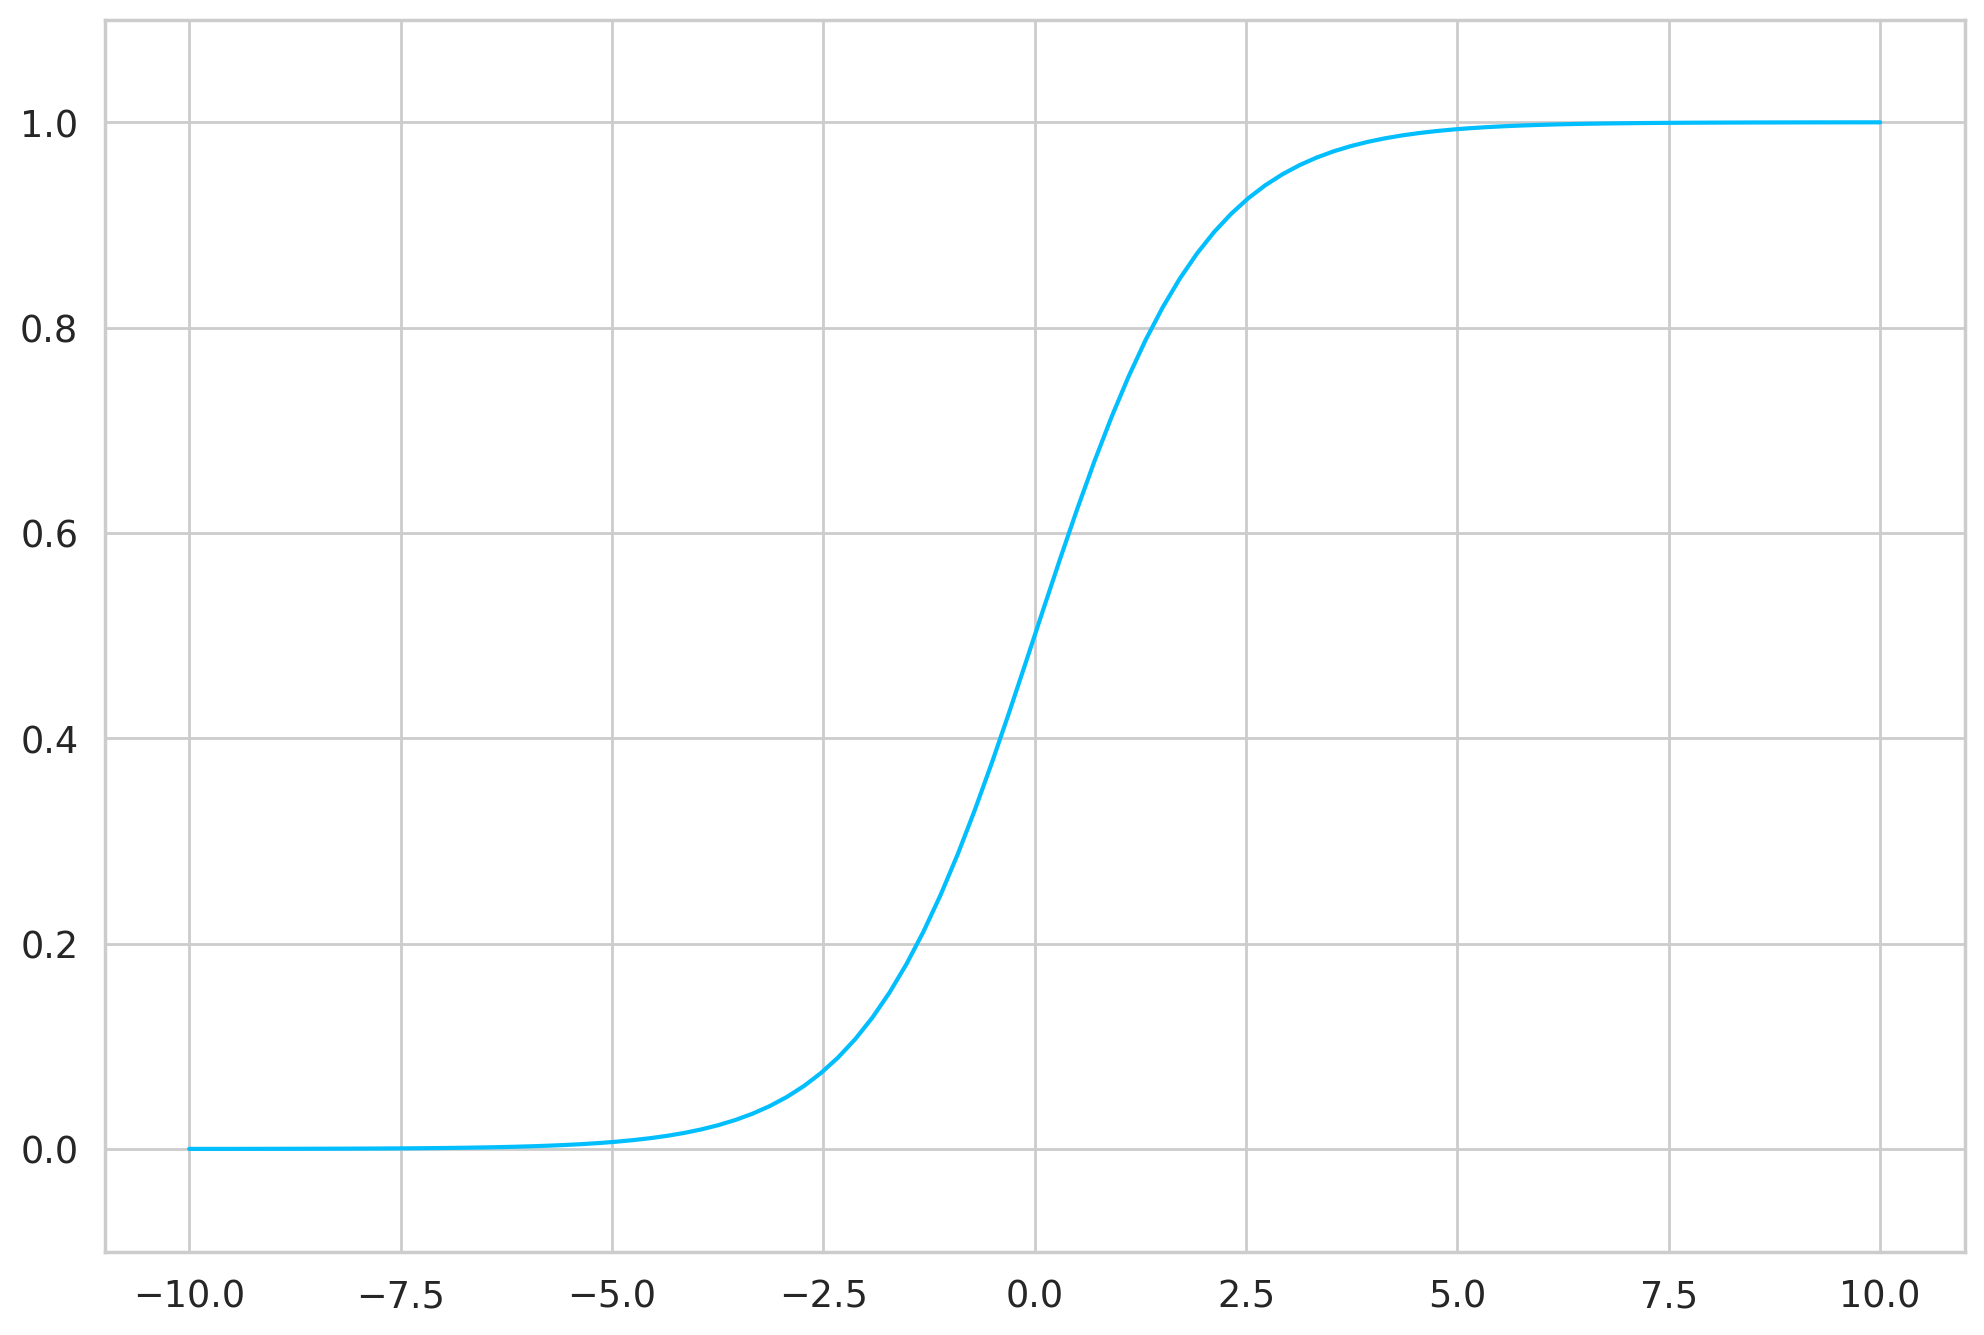

In [18]:
ax = plt.gca()

plt.plot(
  np.linspace(-10, 10, 100),
  torch.sigmoid(torch.linspace(-10, 10, steps=100)).numpy()
)
ax.set_ylim([-0.1, 1.1]);

In [19]:
criterion = nn.BCELoss()

In [20]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [23]:
net = net.to(device)

criterion = criterion.to(device)

In [24]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [25]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):

    y_pred = net(X_train)

    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)

    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

epoch 0
Train set - loss: 2.513, accuracy: 0.779
Test  set - loss: 2.517, accuracy: 0.778

epoch 100
Train set - loss: 0.457, accuracy: 0.792
Test  set - loss: 0.458, accuracy: 0.793

epoch 200
Train set - loss: 0.435, accuracy: 0.801
Test  set - loss: 0.436, accuracy: 0.8

epoch 300
Train set - loss: 0.421, accuracy: 0.814
Test  set - loss: 0.421, accuracy: 0.815

epoch 400
Train set - loss: 0.412, accuracy: 0.826
Test  set - loss: 0.413, accuracy: 0.827

epoch 500
Train set - loss: 0.408, accuracy: 0.831
Test  set - loss: 0.408, accuracy: 0.832

epoch 600
Train set - loss: 0.406, accuracy: 0.833
Test  set - loss: 0.406, accuracy: 0.835

epoch 700
Train set - loss: 0.405, accuracy: 0.834
Test  set - loss: 0.405, accuracy: 0.835

epoch 800
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.835

epoch 900
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.836



In [26]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [27]:
net = torch.load(MODEL_PATH)

In [28]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.80      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



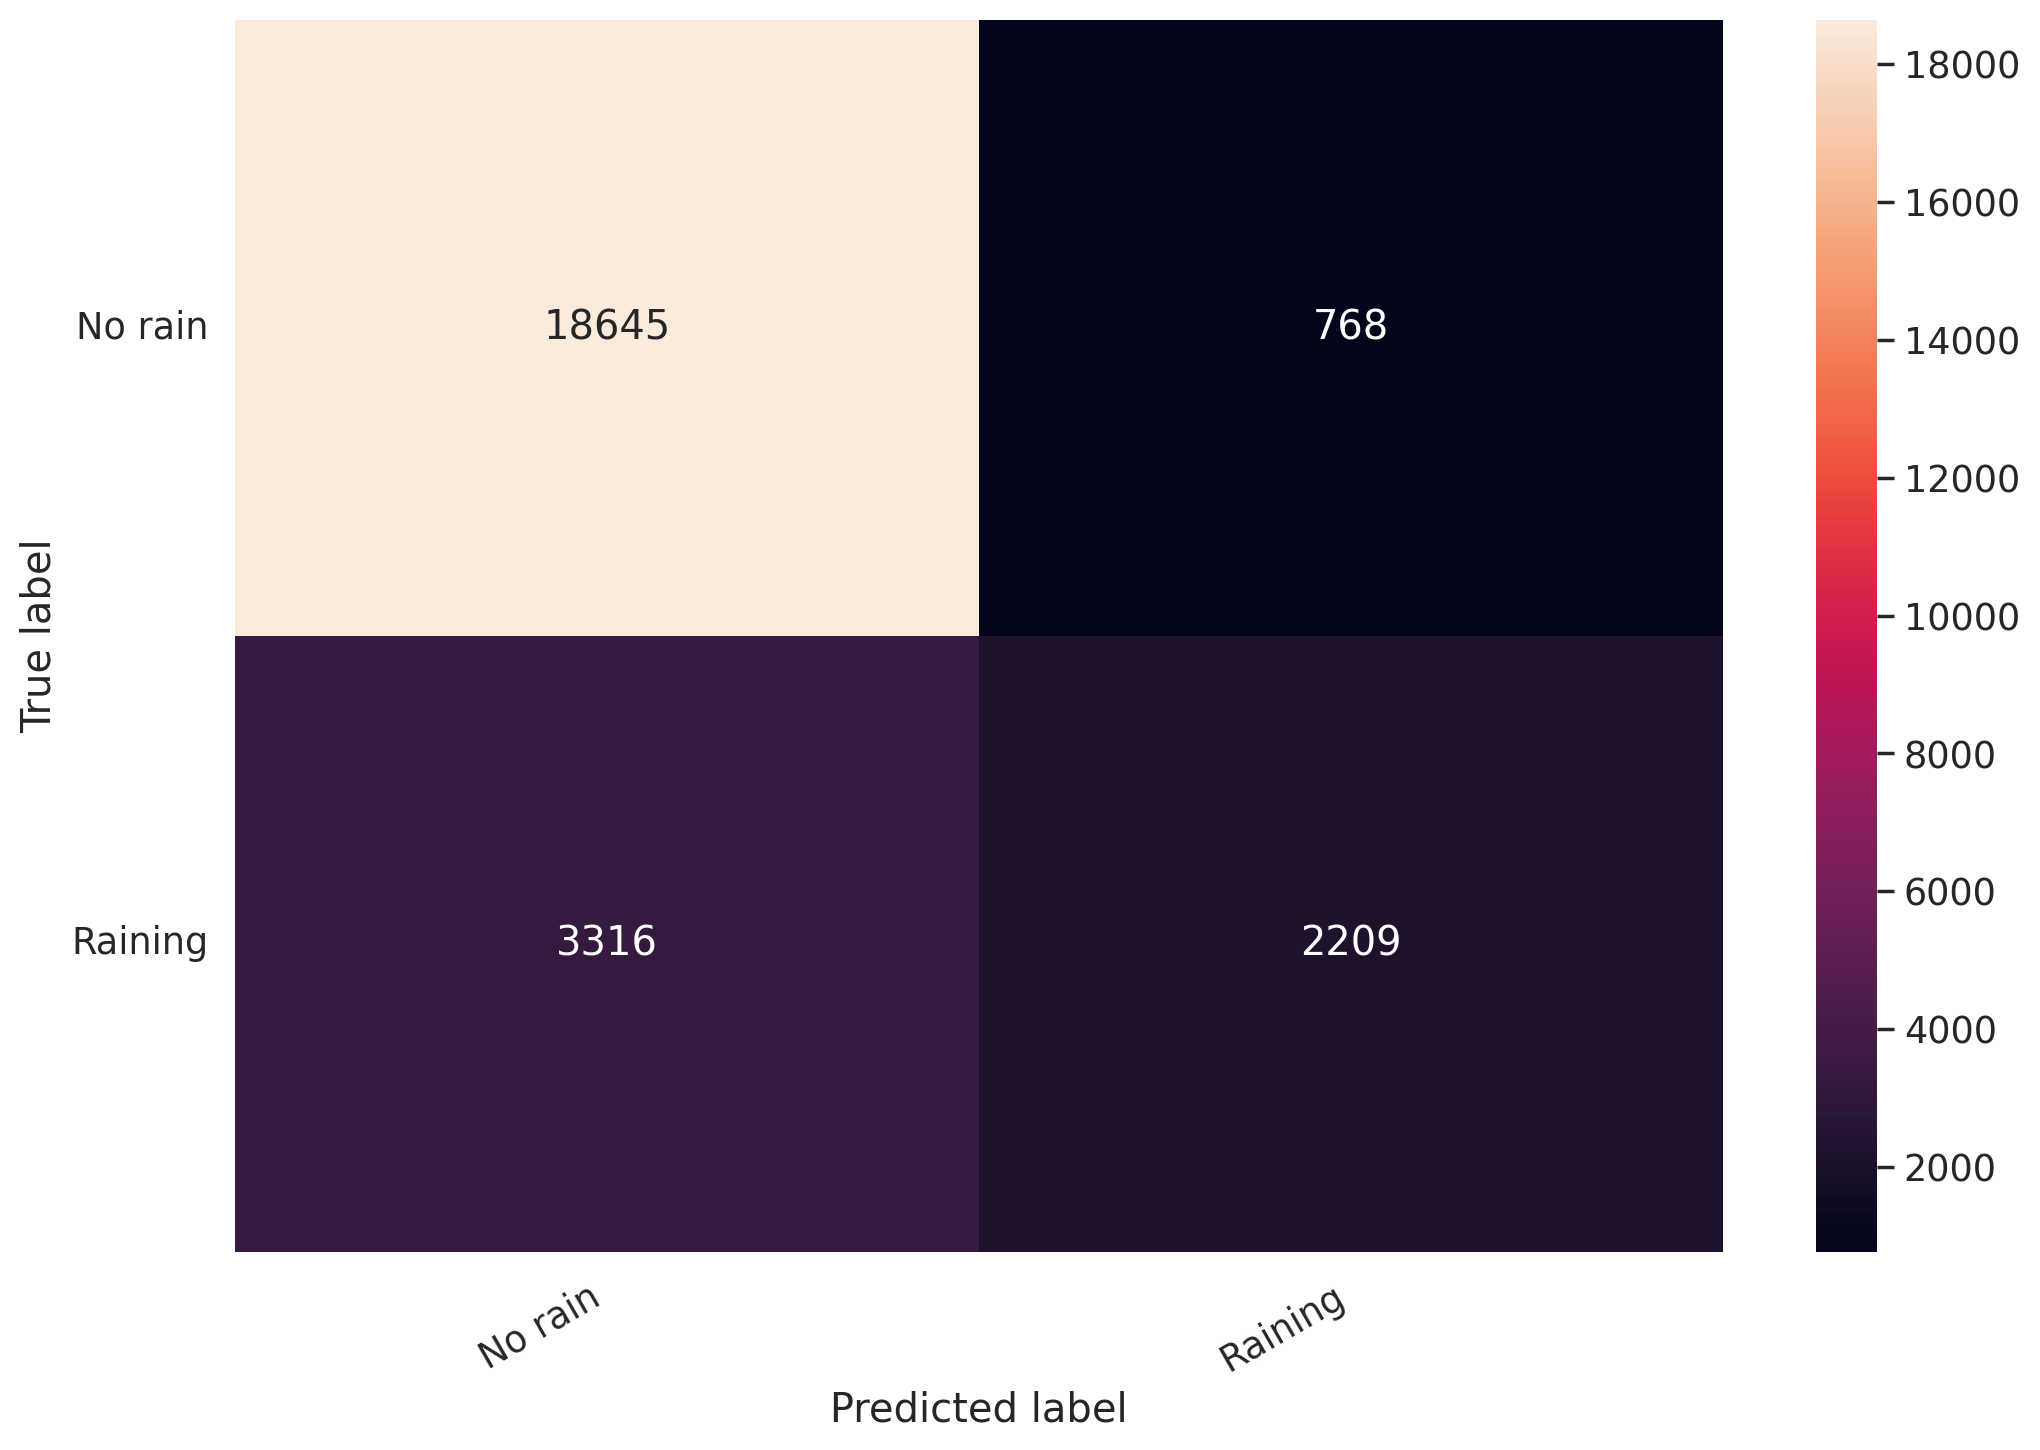

In [29]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [30]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

In [31]:
will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2)

True

In [32]:
will_it_rain(rainfall=0, humidity=1, rain_today=False, pressure=100)

False